# Modeling Hot Water Energy

### Select the parameters for the experiment and log in the experiment folder

In [1]:
# %%writefile param_sets.json
seed_value = 123  # seed for the experiment
Trial = 3  # number of the experiment

period = 6  # the period to sample the data at. 1 period= 5 minutes

inputcols = ['oat', 'orh', 'sat', 'ghi', 'hw_sf', 'hw_st',
             'hx_vlv1']  # input predictors
outputcols = ['hwe']  # output targets
input_timesteps = 1  # number of timesteps for the input sequence
output_timesteps = 1  # number of timesteps for the output sequence

# Smoothing
smooth_data = True  # whetter to smooth the data or not
order = 5  # order of the filer
T = 300  # sampling_period in seconds
fs = 1 / 300  # sample rate, Hz
cutoff = 0.0001  # desired cutoff frequency of the filter, Hz

# adjust out of phase data
adjust_lag = True  # whether to adjust the lag for certain columns
lag_columns = outputcols  # choose columns to adjust lag
data_lag = -1  # lag by how many periods: negative means shift column upwards

# aggregate data based on period
aggregate_data = True  # aggregate data or not
rolling_sum_target = ['hwe', 'hw_sf']  # create sum aggregate for these columns
rolling_mean_target = [
    'hw_st', 'hw_rt', 'oat', 'sat', 'orh', 'ghi', 'avg_stpt','hx_vlv1'
]  # create mean aggregate for these columns

# create temporal batches of data: df2dflist
days, hours = 7, 0

# Custom way to create Training Data
data_weeks = 52  # Create a large initial block 6 months ~ 26 weeks of training and testing data
create_lag = 0  # Create further lags in the output
scaling = True  # Scale the input and output features
feature_range = (0, 1)  # Scaling range
reshaping = True  # reshape data according to (batch_size, time_steps, features)

# model configuration
modelconfig = {
    'lstm_hidden_units': 16,
    'lstm_no_layers': 4,
    'dense_hidden_units': 1,
    'dense_no_layers': 0,
    'retrain_from_layers': 0,
    'stateful': True,
    'train_batchsize':data_weeks-1,
    'test_batchsize':1, # we are doing online prediction
    'train_epochs': 5000,
}

# wheter doing adaptive for fixed learning
adaptive_control = True  # whether we relearn or keep it fixed
path = '../results/' + outputcols[0] + '_model{}/'.format(
    Trial) + 'adaptive/' * adaptive_control + 'fixed/' * (1 - adaptive_control)
#!rm -rf ../results/lstm_hwe_trial8/adaptive

#model design considerations
modeldesigndone = False  # whether model will be reinitialized
initial_epoch = 0  # the start epoch number for the training

# These are automatically superseded and ignored if adaptive_control is set to False
retain_prev_model = False  # retain weights of model from previous training
freeze_model = False  # freeze weights of certain layers
reinitialize = False  # reinitialize the weights of certain layers
model_saved = False  # whether model has been saved once
test_model_created = False  # create an idectical model for inline predicton

# data used for learning the model
datapath = '../data/processed/interpolated/buildingdata_interpolated.pkl'

### Set Seed in numpy, Keras and TF for reproducability
### Import modules
### Set GPU configurations

In [2]:
import shutil
import os
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# Enable '0' or disable '-1' GPU use
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# including the project directory to the notebook level
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import json
from tqdm import tqdm
import parse
import warnings
from matplotlib.dates import date2num

In [3]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    import tensorflow as tf
    #tf.random.set_seed(seed_value)
    # for later versions: 
    tf.compat.v1.set_random_seed(seed_value)
    config = tf.ConfigProto(log_device_placement=False)
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    
    from keras import backend as K
    from nn_source import models as mp

from dataprocess import dataprocessor as dp
from dataprocess import plotutils as pu

Using TensorFlow backend.


In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir '../results/lstm_hwe_trial1/loginfo/' --port 8200

### Create Folder to save models and tensorboard logs

In [4]:
# create the results directory
try:
    os.makedirs(path)
except FileExistsError:
    files = os.listdir(path)
    for f in files:
        try:
            shutil.rmtree(path + f)
        except NotADirectoryError:
            os.remove(path + f)
        
os.mkdir(path + 'loginfo')

### Save the experiment parameters and configurations

In [5]:
#save the values
paramsdict = {
    
    'seed_value' : seed_value,
    
    'period':period,
    
    'inputcols':inputcols,
    'outputcols':outputcols,
    'input_timesteps':input_timesteps,
    'output_timesteps':output_timesteps,
    
    'smooth_data': smooth_data,
    'order' : 5,
    'T' : T,
    'fs' : fs,
    'cutoff' : cutoff,
    
    'adjust_lag' : adjust_lag,
    'lag_columns' : lag_columns,
    'data_lag' : data_lag,
    
    'aggregate_data' : aggregate_data,
    'rolling_sum_target' : rolling_sum_target,
    'rolling_mean_target' : rolling_mean_target,
    
    'days':days,
    'hours':hours,
    
    'data_weeks' : data_weeks,
    'create_lag' : create_lag,
    'scaling' : scaling,
    'feature_range' : feature_range,
    'reshaping' : reshaping,
    
    'modelconfig' : modelconfig,
    
    'adaptive_control':adaptive_control,
    'path':path,
    
    'modeldesigndone' : modeldesigndone,
    'initial_epoch' : initial_epoch,
    
    'retain_prev_model' : retain_prev_model,
    'freeze_model' : freeze_model,
    'reinitialize' : reinitialize,
    'model_saved' : model_saved,
    'test_model_created': test_model_created,
    
    'datapath' : datapath,
    
    
}
    
# with open(path+'params.json', 'r') as fp:
#     param2dict = json.load(fp)

with open(path+'params.json', 'w') as fp:
    json.dump(paramsdict, fp, indent=4)

### Read the cleaned data

In [6]:
# read the pickled file for ahu data
dfdata = dp.readfile(datapath)

# return pickled df
df = dfdata.return_df(processmethods=['file2df'])

# show data
df.head()

,oat,sat,orh,hwe,cwe,ghi,avg_stpt,flow,hw_sf,hw_st,hw_rt,hx_vlv1
Time,,,,,,,,,,,,
2018-07-13 07:50:00,80.913567,79.320808,82.0,0.0,32.546185,562.0,69.52381,39.534317,0.0,94.427994,89.589584,0.276543
2018-07-13 07:55:00,80.913567,79.023285,82.0,0.0,29.293947,580.0,69.52381,39.809956,0.0,94.125771,89.589584,0.276543
2018-07-13 08:00:00,80.615402,79.023285,82.0,0.0,30.685425,597.0,69.52381,39.174774,0.0,94.125771,89.589584,0.276543
2018-07-13 08:05:00,80.303123,79.023285,82.0,0.0,30.074446,614.0,69.52381,35.745533,0.0,93.816162,89.229790,0.276543
2018-07-13 08:10:00,80.303123,79.023285,79.0,0.0,29.646845,625.0,69.52381,34.858036,0.0,93.816162,89.229790,0.276543


### Smooth the data

In [7]:
if smooth_data:
    df = dp.dfsmoothing(df=df,
                        column_names=list(df.columns),
                        order=order,
                        Wn=cutoff,
                        T=T)

### Adjust lag for certain columns if needed

In [8]:
if adjust_lag:
    df = dp.createlag(df, lag_columns, lag=data_lag)

### Create aggregate data: aggregate specified columns at specified intervals

In [9]:
# return a new column which is the sum of previous window_size values
def window_sum(df_, window_size: int, column_names: list):
    return df_[column_names].rolling(window=window_size, min_periods=window_size).sum()

# return a new column which is the average of previous window_size values
def window_mean(df_, window_size: int, column_names: list):
    return df_[column_names].rolling(window=window_size, min_periods=window_size).mean()

# rolling_sum_output = ['{}min_{}_sum'.format(5*period,target) for target in rolling_sum_target]
# rolling_mean_output = ['{}min_{}_mean'.format(5*period,target) for target in rolling_mean_target]

if aggregate_data:
    
    # rolling sum
    df[rolling_sum_target] =  window_sum(df, window_size=period, column_names=rolling_sum_target)
    
    # rolling mean
    df[rolling_mean_target] =  window_mean(df, window_size=period, column_names=rolling_mean_target)
    
    df = dp.dropNaNrows(df)
    
    # Sample the data at period intervals
    df = dp.sample_timeseries_df(df, period=period)

### Create temporal chunks of data

In [10]:
# Creating a list of "days" day dataframes for training
dflist = dp.df2dflist_alt(df[inputcols+outputcols],
                      subsequence=True,
                      period=period,
                      days=days,
                      hours=hours)
print('Length of dflist: {}'.format(len(dflist)))

Length of dflist: 82


### Custom way to create Training Data

In [11]:
# Since we are training across time, we need to ensure the input and output time steps are now 1
# otherwise the rearrangment of the data for batch speedup will be violated
assert (input_timesteps == 1) & (
    output_timesteps == 1), "Input and Output timesteps must be 1 for this notebook"

#### Create placeholder and functions

In [12]:
from pandas import concat, Timedelta


def quickmerge(listdf):
    return concat(listdf)


def df_list_reshape(datablock_df):
    new_df_list = []
    for i in range(int(10080 / (5 * period))):
        new_df_list.append(
            datablock_df[(datablock_df.index - datablock_df.index[i]) %
                         Timedelta('7 days') == '0 days 00:00:00'])
    return new_df_list

weeklist = []  # create list of training, testing arrays

#### Initial Data Block for offline training

In [13]:
datablock_pre = dflist[0:data_weeks-1]
datablock_train = quickmerge(datablock_pre)
datablock_train = quickmerge(df_list_reshape(datablock_train))
datablock_test = dflist[data_weeks-1]
data_block = quickmerge([datablock_train, datablock_test])
splitvalue = 336   # (data_weeks - 1) / data_weeks  # One week for training


X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        data_block,
        predictorcols=inputcols,
        outputcols=outputcols,
        scaling=scaling,
        feature_range=feature_range,
        reshaping=reshaping,
        lag=create_lag,
        split=splitvalue,
    input_timesteps=input_timesteps,
    output_timesteps = output_timesteps
    )

idx_end = -max(X_test.shape[1],y_test.shape[1])
idx_start = idx_end - X_test.shape[0] + 1
test_idx = data_block.index[[i for i in range(idx_start, idx_end+1, 1)]]

weeklist.append({
        'Id':'Year-{}-Week-{}'.format(str(datablock_test.index[0].year), 
                                      str(datablock_test.index[0].week)),
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
        'y_scaler':y_scaler,
        'X_scaler':X_scaler,
        'test_idx':test_idx,
    })

#### Create small blocks of data for weekly training

In [14]:
for weekdata in dflist[data_weeks:]:
    
    datablock_pre = datablock_pre[1:]+[datablock_test]
    datablock_train = quickmerge(datablock_pre)
    datablock_train = quickmerge(df_list_reshape(datablock_train))
    datablock_test = weekdata
    data_block = quickmerge([datablock_train, datablock_test])
    splitvalue = 336   # (data_weeks - 1) / data_weeks  # One week for training
    
    # and add new week data from weekdata
    X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        data_block,
        predictorcols=inputcols,
        outputcols=outputcols,
        scaling=scaling,
        feature_range=feature_range,
        reshaping=reshaping,
        lag=create_lag,
        split=splitvalue,
    input_timesteps=input_timesteps,
    output_timesteps = output_timesteps
    )

    idx_end = -max(X_test.shape[1],y_test.shape[1])
    idx_start = idx_end - X_test.shape[0] + 1
    test_idx = data_block.index[[i for i in range(idx_start,idx_end+1,1)]]

    weeklist.append({
        'Id':'Year-{}-Week-{}'.format(str(datablock_test.index[-1].year), 
                                      str(datablock_test.index[-1].week)),
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
        'y_scaler':y_scaler,
        'X_scaler':X_scaler,
        'test_idx':test_idx,
    })
    
print('Length of weeklist: {}'.format(len(weeklist)))

Length of weeklist: 31


#### Print size and shape of data to feed to the LSTM for sanity checks

In [15]:
for week in weeklist:
    for key,value in week.items():
        if (key != 'y_scaler') & (key != 'X_scaler') :
            print("name: {}, shape: {}".format(key, value.shape if not isinstance(value,str) else value))

name: Id, shape: Year-2019-Week-27
name: X_train, shape: (17136, 1, 7)
name: y_train, shape: (17136, 1, 1)
name: X_test, shape: (336, 1, 7)
name: y_test, shape: (336, 1, 1)
name: test_idx, shape: (336,)
name: Id, shape: Year-2019-Week-29
name: X_train, shape: (17136, 1, 7)
name: y_train, shape: (17136, 1, 1)
name: X_test, shape: (336, 1, 7)
name: y_test, shape: (336, 1, 1)
name: test_idx, shape: (336,)
name: Id, shape: Year-2019-Week-30
name: X_train, shape: (17136, 1, 7)
name: y_train, shape: (17136, 1, 1)
name: X_test, shape: (336, 1, 7)
name: y_test, shape: (336, 1, 1)
name: test_idx, shape: (336,)
name: Id, shape: Year-2019-Week-31
name: X_train, shape: (17136, 1, 7)
name: y_train, shape: (17136, 1, 1)
name: X_test, shape: (336, 1, 7)
name: y_test, shape: (336, 1, 1)
name: test_idx, shape: (336,)
name: Id, shape: Year-2019-Week-32
name: X_train, shape: (17136, 1, 7)
name: y_train, shape: (17136, 1, 1)
name: X_test, shape: (336, 1, 7)
name: y_test, shape: (336, 1, 1)
name: test_idx,

#### Add weekly train test data to modelconfig dictionary for ease of training

In [16]:
modelconfig['weeklist'] = weeklist

###  Clear the Tensorflow graph from previous training

In [17]:
try:
    del nn_model
except NameError:
    pass

K.clear_session()

### Inspect model architecture

In [ ]:
# weekdata = modelconfig['weeklist'][0]
# X_train = weekdata['X_train']
# y_train = weekdata['y_train']
# X_test = weekdata['X_test']
# y_test = weekdata['y_test']
# y_scaler = weekdata['y_scaler']

# #Instantiate learner model
# nn_model = mp.seq2seq_model(path,
#                       inputdim=X_train.shape[-1],
#                       outputdim=y_train.shape[-1],
#                       period=period)

# # Desing model architecture
# nn_model.design_network(lstmhiddenlayers=[modelconfig['lstm_hidden_units']] * (2*modelconfig['lstm_no_layers']),
#                    densehiddenlayers=[modelconfig['dense_hidden_units']] * modelconfig['dense_no_layers'],
#                    dropoutlist=[[], []],
#                    batchnormalizelist=[[], []])

# # compile model
# nn_model.model_compile()

# nn_model.model.summary()

### Perform relearning on chunks of temporal data

In [18]:
for weekno, weekdata in enumerate(tqdm(modelconfig['weeklist'][:14])):

    X_train = weekdata['X_train']
    y_train = weekdata['y_train']
    X_test = weekdata['X_test']
    y_test = weekdata['y_test']
    y_scaler = weekdata['y_scaler']
    X_scaler = weekdata['X_scaler']

    if not modeldesigndone:
        
        try:
            del nn_model
        except NameError:
            pass

        K.clear_session()

        #Instantiate learner model
        nn_model = mp.stateful_LSTM_model(path,
                                          inputdim=X_train.shape[-1],
                                          outputdim=y_train.shape[-1],
                                          input_timesteps=input_timesteps,
                                          output_timesteps = output_timesteps,
                                          period=period,
                                          stateful = modelconfig['stateful'],
                                          batch_size=modelconfig['train_batchsize'])

        # Desing model architecture
        nn_model.design_network(lstmhiddenlayers=[modelconfig['lstm_hidden_units']] * modelconfig['lstm_no_layers'],
                                densehiddenlayers=[modelconfig['dense_hidden_units']] * modelconfig['dense_no_layers'],
                                dropoutlist=[[], []],
                                batchnormalizelist=[[], []])
        
        # load the trained model weights if we want to: here some layer weights may be reinitialized; see below
        if model_saved & retain_prev_model:
            nn_model.model.load_weights('IntermediateModel.h5')
        

        # compile model
        nn_model.model_compile()

        # modeldesigndone = True: needed for Keras limitations: Tensorboard crashes if we relearn on original model    

    # train the model for adaptive model and fixed after first round for fixed control
    if adaptive_control | (weekno==0):
        history = nn_model.train_model(X_train,
                                       y_train,
                                       epochs=modelconfig['train_epochs'],
                                       initial_epoch=initial_epoch)
        try:
            initial_epoch += len(history.history['loss'])
        except KeyError:
            pass
    
        # save the model only if trained at least once- needed for prediction model
        nn_model.model.save('IntermediateModel.h5')
        model_saved = True
        
    # return hidden states
    hc = nn_model.get_final_state(X_train)
    # hidden initial state for prediction
    hc_list = [[K.constant(hc[2*i][[-1],:]),K.constant(hc[2*i + 1][[-1],:])] for i in range(int(len(hc)/2))]
    
    if not test_model_created:
        
        # Separate predictor for predicting online: only difference is test batch size
        nn_model_pred = mp.stateful_LSTM_model(path,
                                               inputdim=X_train.shape[-1],
                                               outputdim=y_train.shape[-1],
                                               input_timesteps=input_timesteps,
                                               output_timesteps = output_timesteps,
                                               period=period,
                                               stateful = modelconfig['stateful'],
                                               batch_size=modelconfig['test_batchsize'])
        
        # Desing model architecture
        nn_model_pred.design_network(lstmhiddenlayers=[modelconfig['lstm_hidden_units']] * modelconfig['lstm_no_layers'],
                                densehiddenlayers=[modelconfig['dense_hidden_units']] * modelconfig['dense_no_layers'],
                                dropoutlist=[[], []],
                                batchnormalizelist=[[], []],
                                initial_state = hc_list)
        
        test_model_created = False
        
    # load the trained model weights
    nn_model_pred.model.load_weights('IntermediateModel.h5')
    # compile model
    nn_model_pred.model_compile()

    # evaluate the model for metrics at this stage
    # train and test plots as well as logged errors inside the text file
    preds_test = nn_model_pred.evaluate_model( X_test,
                                               y_test,
                                               y_scaler,
                                               scaling=True,
                                               saveplot=True,
                                               Idx=weekdata['Id'],
                                               outputdim_names=outputcols)
    
    # do a detailed plot instead
    pu.detailedplot(period * 5,
                    xs = date2num(list(weekdata['test_idx'])),
                    outputdim=len(outputcols),
                    output_timesteps=output_timesteps,
                    input_timesteps=input_timesteps,
                    pred=preds_test,
                    target=y_test,
                    X_var=X_test,
                    saveloc=path,
                    scaling=True,
                    Xscaler=X_scaler,
                    yscaler=y_scaler,
                    typeofplot='test',
                    Idx=weekdata['Id'])

    if adaptive_control:
        
        # freeze all but dense layers at the top and compile with new weights
        if freeze_model:
            for layer in nn_model.model.layers[:-modelconfig['retrain_from_layers']]:
                layer.trainable = False

        # for relearning, reinitialize top few layers
        if reinitialize:
            for layer in nn_model.model.layers[-modelconfig['retrain_from_layers']:]:
                layer.kernel.initializer.run(session=K.get_session())
                layer.bias.initializer.run(session=K.get_session())

        # recompile model
        if freeze_model | reinitialize:
            nn_model.model_compile()
            
            # save the model- needed for Keras limitations: Tensorboard crashes if we relearn on original model with
            # reinitialized weights; solution: we create new model and load these weights
            nn_model.model.save('IntermediateModel.h5')
            model_saved = True
            
            freeze_model = False
            # reinitialize = True

  0%|          | 0/14 [00:00<?, ?it/s]




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/5000
 - 4s - loss: 0.0213 - dense_1_loss: 0.0213
Epoch 2/5000
 - 3s - loss: 0.0127 - dense_1_loss: 0.0127
Epoch 3/5000
 - 3s - loss: 0.0127 - dense_1_loss: 0.0127
Epoch 4/5000
 - 3s - loss: 0.0101 - dense_1_loss: 0.0101
Epoch 5/5000
 - 3s - loss: 0.0100 - dense_1_loss: 0.0100
Epoch 6/5000
 - 3s - loss: 0.0104 - dense_1_loss: 0.0104
Epoch 7/5000
 - 3s - loss: 0.0081 - dense_1_loss: 0.0081
Epoch 8/5000
 - 3s - loss: 0.0080 - dense_1_loss: 0.0080
Epoch 9/5000
 - 3s - loss: 0.0079 - dense_1_loss: 0.0079
Epoch 10/5000
 - 3s - loss: 0.0079 - dense_1_loss: 0.0079
Epoch 11/5000
 - 3s - loss: 0.0078 - dense_1_loss: 0.0078
Epoch 12/5000
 - 3s - loss: 0.0075 - dense_1_loss: 0.0075
Epoch 13/5000
 - 3s - loss: 0.0073 - dense_1_loss: 0.0073
Epoch 14/5000
 - 3s - loss: 0.0070 - dense_1_loss: 0.0070
Epoch 15/5000
 - 3s - loss: 0.0068 - dense_1_loss: 0.0068
Epoch 16/5000
 - 3s - loss: 0.0067 - den

  7%|▋         | 1/14 [01:57<25:28, 117.61s/it]

Epoch 41/5000
 - 4s - loss: 0.0573 - dense_1_loss: 0.0573
Epoch 42/5000
 - 3s - loss: 0.0573 - dense_1_loss: 0.0573
Epoch 43/5000
 - 3s - loss: 0.0573 - dense_1_loss: 0.0573
Epoch 44/5000
 - 3s - loss: 0.0573 - dense_1_loss: 0.0573
Epoch 45/5000
 - 3s - loss: 0.0573 - dense_1_loss: 0.0573
Epoch 46/5000
 - 3s - loss: 0.0573 - dense_1_loss: 0.0573


 14%|█▍        | 2/14 [02:22<17:55, 89.65s/it] 

Epoch 47/5000
 - 4s - loss: 0.0227 - dense_1_loss: 0.0227
Epoch 48/5000
 - 3s - loss: 0.0129 - dense_1_loss: 0.0129
Epoch 49/5000
 - 3s - loss: 0.0110 - dense_1_loss: 0.0110
Epoch 50/5000
 - 3s - loss: 0.0121 - dense_1_loss: 0.0121
Epoch 51/5000
 - 2s - loss: 0.0109 - dense_1_loss: 0.0109
Epoch 52/5000
 - 3s - loss: 0.0083 - dense_1_loss: 0.0083
Epoch 53/5000
 - 3s - loss: 0.0078 - dense_1_loss: 0.0078
Epoch 54/5000
 - 3s - loss: 0.0077 - dense_1_loss: 0.0077
Epoch 55/5000
 - 3s - loss: 0.0075 - dense_1_loss: 0.0075
Epoch 56/5000
 - 3s - loss: 0.0073 - dense_1_loss: 0.0073
Epoch 57/5000
 - 3s - loss: 0.0071 - dense_1_loss: 0.0071
Epoch 58/5000
 - 2s - loss: 0.0068 - dense_1_loss: 0.0068
Epoch 59/5000
 - 3s - loss: 0.0066 - dense_1_loss: 0.0066
Epoch 60/5000
 - 2s - loss: 0.0064 - dense_1_loss: 0.0064
Epoch 61/5000
 - 2s - loss: 0.0062 - dense_1_loss: 0.0062
Epoch 62/5000
 - 3s - loss: 0.0061 - dense_1_loss: 0.0061
Epoch 63/5000
 - 3s - loss: 0.0061 - dense_1_loss: 0.0061
Epoch 64/5000


 21%|██▏       | 3/14 [04:06<17:13, 93.98s/it]

Epoch 83/5000
 - 4s - loss: 0.0197 - dense_1_loss: 0.0197
Epoch 84/5000
 - 3s - loss: 0.0131 - dense_1_loss: 0.0131
Epoch 85/5000
 - 3s - loss: 0.0114 - dense_1_loss: 0.0114
Epoch 86/5000
 - 3s - loss: 0.0112 - dense_1_loss: 0.0112
Epoch 87/5000
 - 3s - loss: 0.0120 - dense_1_loss: 0.0120
Epoch 88/5000
 - 3s - loss: 0.0104 - dense_1_loss: 0.0104
Epoch 89/5000
 - 3s - loss: 0.0095 - dense_1_loss: 0.0095
Epoch 90/5000
 - 3s - loss: 0.0098 - dense_1_loss: 0.0098
Epoch 91/5000
 - 3s - loss: 0.0103 - dense_1_loss: 0.0103
Epoch 92/5000
 - 3s - loss: 0.0081 - dense_1_loss: 0.0081
Epoch 93/5000
 - 3s - loss: 0.0074 - dense_1_loss: 0.0074
Epoch 94/5000
 - 3s - loss: 0.0069 - dense_1_loss: 0.0069
Epoch 95/5000
 - 3s - loss: 0.0068 - dense_1_loss: 0.0068
Epoch 96/5000
 - 3s - loss: 0.0070 - dense_1_loss: 0.0070
Epoch 97/5000
 - 3s - loss: 0.0069 - dense_1_loss: 0.0069
Epoch 98/5000
 - 3s - loss: 0.0067 - dense_1_loss: 0.0067
Epoch 99/5000
 - 3s - loss: 0.0066 - dense_1_loss: 0.0066
Epoch 100/5000

 29%|██▊       | 4/14 [05:36<15:27, 92.76s/it]

Epoch 113/5000
 - 4s - loss: 0.0245 - dense_1_loss: 0.0245
Epoch 114/5000
 - 3s - loss: 0.0133 - dense_1_loss: 0.0133
Epoch 115/5000
 - 3s - loss: 0.0118 - dense_1_loss: 0.0118
Epoch 116/5000
 - 3s - loss: 0.0103 - dense_1_loss: 0.0103
Epoch 117/5000
 - 3s - loss: 0.0104 - dense_1_loss: 0.0104
Epoch 118/5000
 - 3s - loss: 0.0099 - dense_1_loss: 0.0099
Epoch 119/5000
 - 3s - loss: 0.0081 - dense_1_loss: 0.0081
Epoch 120/5000
 - 3s - loss: 0.0064 - dense_1_loss: 0.0064
Epoch 121/5000
 - 3s - loss: 0.0062 - dense_1_loss: 0.0062
Epoch 122/5000
 - 3s - loss: 0.0054 - dense_1_loss: 0.0054
Epoch 123/5000
 - 2s - loss: 0.0056 - dense_1_loss: 0.0056
Epoch 124/5000
 - 3s - loss: 0.0054 - dense_1_loss: 0.0054
Epoch 125/5000
 - 3s - loss: 0.0046 - dense_1_loss: 0.0046
Epoch 126/5000
 - 3s - loss: 0.0046 - dense_1_loss: 0.0046
Epoch 127/5000


KeyboardInterrupt: 

### Plot the CVRMSE error on chunks of temporal data

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


Name of the file:  ../results/hwe_model3/adaptive/30min Results_File.txt


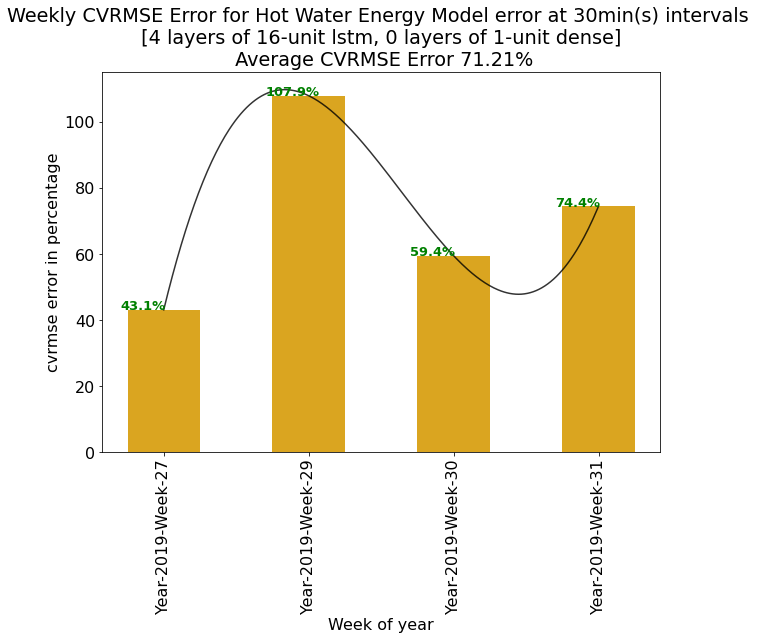

In [19]:
# Open a file
fo = open(path + "{}min Results_File.txt".format(5*period), "r")
print("Name of the file: ", fo.name)
lines = fo.readlines()

parse_format = 'Year-{}-Week-{}-Time Step {}: {} RMSE={} |{} CVRMSE={} |{} MAE={}'
stats = {
    'Train': {
        'rmse': [],
        'cvrmse': [],
        'mae': []
    },
    'Test': {
        'rmse': [],
        'cvrmse': [],
        'mae': []
    }
}
xticklist = []
counter = 0
for line in lines:
    p = parse.parse(parse_format, line)
    stats[p[3]]['rmse'].append(float(p[4]))
    stats[p[5]]['cvrmse'].append(float(p[6]))
    stats[p[7]]['mae'].append(float(p[8]))
    if counter % 1 == 0:
        xticklist.append('Year-{}-Week-{}'.format(p[0], p[1]))
    counter += 1
fo.close()
cvrmse_list = stats['Test']['cvrmse']
cvrmse = sum(cvrmse_list) / len(cvrmse_list)
# from dataprocess import plotutils as pu
plot_args = dict(
    bars=cvrmse_list,
    color='goldenrod',
    bar_label='cvrmse',
    saveloc=path,
    smoothcurve=True,
    bar_annotate=True,
    saveplot=True,
    xlabel='Week of year',
    ylabel='cvrmse error in percentage',
    title=
    'Weekly CVRMSE Error for Hot Water Energy Model error at {5:}min(s) intervals \n [{0:} layers of {1:}-unit lstm, {2:} layers of {3:}-unit dense] \n Average CVRMSE Error {4:.2f}%'
    .format(modelconfig['lstm_no_layers'], modelconfig['lstm_hidden_units'],
            modelconfig['dense_no_layers'], modelconfig['dense_hidden_units'],
            cvrmse,5*period),
    xticklist=xticklist,
    plotwidth=10,
    plotheight=7,
    fontsize=16)
pu.single_bar_plot(**plot_args)

In [ ]:
xticklist

### Code cemetery

In [ ]:
# from keras.utils import plot_model
# plot_model(nn_model.model, to_file='model.png',show_shapes=True,)


# # Check the trainable status of the individual layers
# for layer in nn_model.model.layers:
#     print(layer, layer.trainable, layer.name)


#model.model.summary()


#nn_model.model.layers[-1].input_shape
#model.model.layers[-1].kernel.initializer.run(session=K.get_session())
#model.model.layers[-1].bias.initializer.run(session=K.get_session())
#nn_model.model.layers[-1].output_shape